## Custom BERT Classifier on combined_notes

---



In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score
import pandas as pd

In [ ]:
def load_suhi_data(data_file):
    df = pd.read_csv(data_file)
    df.dropna(subset=['combined_notes', 'day_readmit'], inplace=True)
    df['day_readmit'] = df['day_readmit'].apply(lambda x: 0.0 if x == 2.0 else x)
    texts = df['combined_notes'].tolist()
    labels = [1 if readmit == 1.0 else 0 for readmit in df['day_readmit'].tolist()]
    return texts, labels

In [ ]:
data_file = "/content/SUHI_MATRIX_WITH_CHW_Notes_10_29_2024_with_combined_notes.csv"
texts, labels = load_suhi_data(data_file)

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_length,
            padding='max_length',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Extract [CLS] token output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        class_weights = torch.tensor([1.0, len(train_labels) / sum(train_labels)]).to(device)
        loss = nn.CrossEntropyLoss(weight=class_weights)(outputs, labels)
        # loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()


In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    probabilities = []  # To store predicted probabilities for ROC-AUC

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Get model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)
            probabilities.extend(probs.cpu().numpy()[:, 1])  # Probabilities for class 1
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predictions)
    report = classification_report(actual_labels, predictions)

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(actual_labels, probabilities)

    return accuracy, report, roc_auc

In [ ]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 512
batch_size = 4
num_epochs = 10
learning_rate = 2e-5

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report, roc_auc = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(report)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.8511
ROC-AUC: 0.5477
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       263
           1       0.00      0.00      0.00        46

    accuracy                           0.85       309
   macro avg       0.43      0.50      0.46       309
weighted avg       0.72      0.85      0.78       309

Epoch 2/10
Validation Accuracy: 0.8447
ROC-AUC: 0.5864
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       263
           1       0.25      0.02      0.04        46

    accuracy                           0.84       309
   macro avg       0.55      0.51      0.48       309
weighted avg       0.76      0.84      0.79       309

Epoch 3/10
Validation Accuracy: 0.6181
ROC-AUC: 0.5441
              precision    recall  f1-score   support

           0       0.87      0.65      0.74       263
           1       0.18      0.43      0.25        46

    accuracy                

In [ ]:
def predict_readmission(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors='pt',
        max_length=max_length,
        padding='max_length',
        truncation=True
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return "readmit" if preds.item() == 1 else "not_readmit"

## Training traditional ML classifiers on the text embeddings to classify patient readmission

In [2]:
# Import classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Import classifier ensemble, boosting and bagging models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

# Other required libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sentence_transformers import SentenceTransformer, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'xgboost'

## Word frequnecy at document level and corpus level

In [ ]:
len(texts)

1541

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


# Preprocessing
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Document-level word frequencies
doc_frequencies = [Counter(preprocess(doc)) for doc in texts]

# Corpus-level word frequencies
corpus_frequencies = Counter()
for doc_freq in doc_frequencies:
    corpus_frequencies.update(doc_freq)

# Display results
print("Document-level Word Frequencies:")
for i, freq in enumerate(doc_frequencies, 1):
    print(f"Document {i}: {freq}")

print("\nCorpus-level Word Frequencies:")
print(corpus_frequencies)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Document-level Word Frequencies:
Document 1: Counter({'declined': 1})
Document 2: Counter({'sdoh': 1, 'emotional': 1, 'support': 1, 'closed': 1, 'case': 1})
Document 3: Counter({'declined': 1})
Document 4: Counter({'declined': 1})
Document 5: Counter({'looking': 2, 'housing': 2, 'pt': 2, 'needs': 1, 'access': 1, 'elevator': 1, 'powered': 1, 'reached': 1, 'let': 1, 'know': 1, 'currently': 1, 'back': 1, 'hospital': 1, 'reassured': 1, 'spoke': 1, 'status': 1, 'cha': 1, 'closed': 1, 'case': 1})
Document 6: Counter({'emotional': 1, 'support': 1, 'emotiional': 1, 'case': 1, 'cloud': 1})
Document 7: Counter({'declined': 1, 'completed': 1, 'sdoh': 1})
Document 8: Counter({'pcp': 2, 'check': 1, 'see': 1, 'returned': 1, 'visit': 1, 'appointment': 1, 'set': 1})
Document 9: Counter({'pt': 1, 'stated': 1, 'need': 1})
Document 10: Counter({'home': 2, 'spoke': 1, 'pt': 1, 'son': 1, 'pedro': 1, 'stated': 1, 'work': 1, 'patient': 1, 'asked': 1, 'call': 1, 'back': 1, 'gets': 1})
Document 11: Counter({'s

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer

# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


# Initialize stemmer
stemmer = PorterStemmer()

def preprocess_text_stemming(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # Remove punctuation and non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum()]
    # Stem each token
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)


def preprocess_text(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # Remove punctuation and non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum()]
    # Lemmatize each token
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Apply preprocessing to your texts
texts_preprocessed = [preprocess_text_stemming(text) for text in texts]

# Generate embeddings using classical techniques
# Tf-Idf
# tfidf_vectorizer = TfidfVectorizer(min_df=20, max_df=0.7)
# text_embeddings = tfidf_vectorizer.fit_transform(texts)

# # BoW
count_vectorizer = CountVectorizer(min_df=20, max_df=0.7)
text_embeddings = count_vectorizer.fit_transform(texts_preprocessed)


# # # Generate embeddings using Transformer
# word_embedding_model = models.Transformer('bert-base-uncased')
# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
# model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# text_embeddings = model.encode(texts)

# Generate multi layer mean pooled embeddings

# # def get_sentence_embedding_with_mean_pooling(sentence, tokenizer, model, num_layers=4):
# #     # Tokenize input
# #     inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
# #     input_ids = inputs['input_ids'].to(device)
# #     attention_mask = inputs['attention_mask'].to(device)

# #     # Pass through the model
# #     with torch.no_grad():
# #         outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

# #     # Extract all hidden states
# #     hidden_states = outputs.hidden_states  # A tuple of (num_layers + 1) tensors (including embeddings)

# #     # Select the last `num_layers` hidden states
# #     selected_hidden_states = hidden_states[-num_layers:]  # Get last `num_layers`

# #     # Stack and mean-pool across the selected layers
# #     stacked_hidden_states = torch.stack(selected_hidden_states, dim=0)  # Shape: (num_layers, batch_size, seq_len, hidden_size)
# #     mean_pooled_embedding = torch.mean(stacked_hidden_states, dim=0)  # Shape: (batch_size, seq_len, hidden_size)

# #     # Mean-pool across tokens (seq_len) for a sentence-level embedding
# #     sentence_embedding = torch.mean(mean_pooled_embedding, dim=1)  # Shape: (batch_size, hidden_size)

# #     return sentence_embedding

# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # model = BertModel.from_pretrained('bert-base-uncased')
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model.to(device)

# from tqdm import tqdm

# text_embeddings = []
# for text in tqdm(texts):
#     sentence_embedding = get_sentence_embedding_with_mean_pooling(text, tokenizer, model, num_layers=3)
#     text_embeddings.append(sentence_embedding)



# Generate emb

# model = SentenceTransformer('all-MiniLM-L6-v2')  # Pre-trained model
# text_embeddings = model.encode(texts)  # Generate sentence embeddings



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# import pandas as pd

# # Create the DTM
# vectorizer = CountVectorizer()
# dtm = vectorizer.fit_transform(texts)

# Convert to a DataFrame for better readability
dtm_df = pd.DataFrame(text_embeddings.toarray(), columns=count_vectorizer.get_feature_names_out())
dtm_df.index = [f"Document {i+1}" for i in range(len(texts))]

# Display the DTM
print(dtm_df)

               10  30  9am  abl  about  access  addit  address  admit  advis  \
Document 1      0   0    0    0      0       0      0        0      0      0   
Document 2      0   0    0    0      0       0      0        0      0      0   
Document 3      0   0    0    0      0       0      0        0      0      0   
Document 4      0   0    0    0      0       0      0        0      0      0   
Document 5      0   0    0    0      1       1      0        0      0      0   
...            ..  ..  ...  ...    ...     ...    ...      ...    ...    ...   
Document 1537   0   0    0    0      0       0      0        0      0      0   
Document 1538   0   0    0    0      0       0      0        0      0      0   
Document 1539   0   0    0    0      0       0      0        0      0      0   
Document 1540   0   0    0    0      0       0      0        0      0      0   
Document 1541   0   0    0    0      0       0      0        0      1      0   

               ...  will  with  work  w

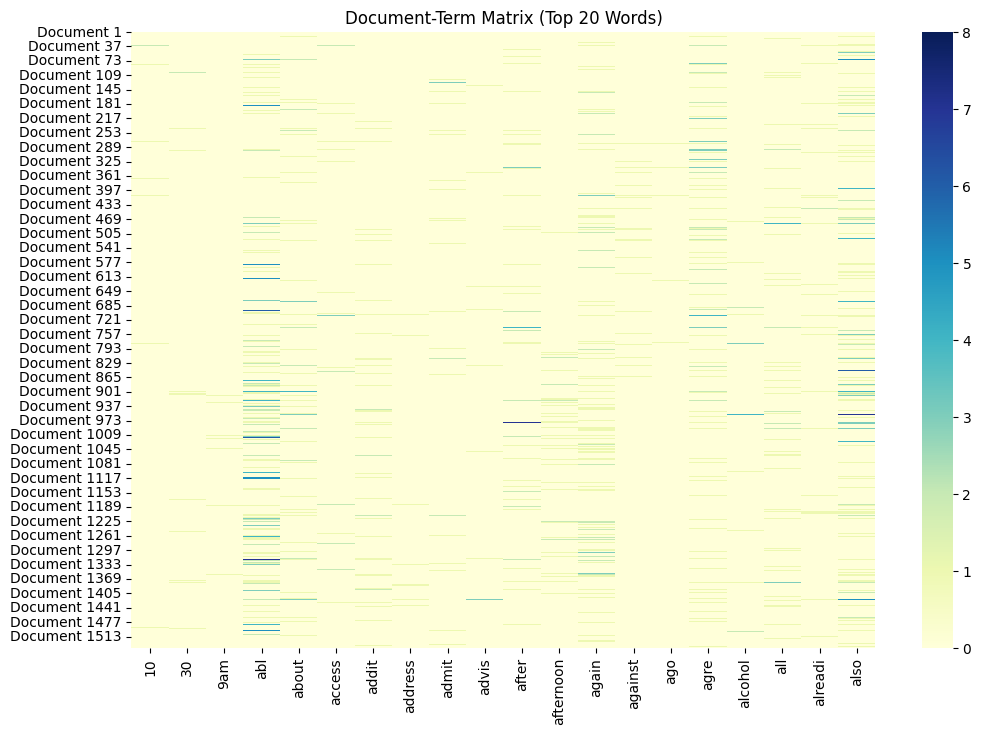

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display a heatmap of the top 20 words
plt.figure(figsize=(12, 8))
sns.heatmap(dtm_df.iloc[:, :20], cmap="YlGnBu", annot=False)
plt.title("Document-Term Matrix (Top 20 Words)")
plt.show()

## Feature Selection

In [ ]:
# Feature selection on Tf-Idf generated embeddings using Random Forest
from sklearn.ensemble import RandomForestClassifier  # Use RandomForestRegressor for regression tasks
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model
rf.fit(text_embeddings, labels)

# Get feature importances
feature_importances = rf.feature_importances_

# Select features based on importance
selector = SelectFromModel(rf, threshold=np.percentile() , prefit=True)

# Transform X to selected features
X_selected = selector.transform(text_embeddings)
X_selected

NameError: name 'text_embeddings' is not defined

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    text_embeddings, labels, test_size=0.2, random_state=42
)

## Random Forest Classifier with default settings

In [ ]:
# Train the Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1
# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{report}")
print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.8414
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       263
           1       0.00      0.00      0.00        46

    accuracy                           0.84       309
   macro avg       0.42      0.49      0.46       309
weighted avg       0.72      0.84      0.78       309

ROC-AUC: 0.6337


## Evaluating different classifiers with default settings

In [ ]:
# Train and evaluate the list of classifiers
classifiers = [
    LogisticRegression(random_state=42),
    SVC(probability=True, random_state=42),
    # GaussianNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier())], voting='soft')
]

for clf in classifiers:
    print(f"Training and evaluating {clf.__class__.__name__}...")
    clf.fit(X_train, y_train) # Training the classifier
    y_pred = clf.predict(X_test) # Predicting with the trained classifier
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    # Evaluate the model
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Classification Report
    report = classification_report(y_test, y_pred)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print(f"ROC-AUC: {roc_auc:.4f}")


Training and evaluating LogisticRegression...
Accuracy: 0.8026
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       263
           1       0.22      0.13      0.16        46

    accuracy                           0.80       309
   macro avg       0.54      0.53      0.53       309
weighted avg       0.76      0.80      0.78       309

ROC-AUC: 0.5538
Training and evaluating SVC...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Accuracy: 0.8511
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       263
           1       0.00      0.00      0.00        46

    accuracy                           0.85       309
   macro avg       0.43      0.50      0.46       309
weighted avg       0.72      0.85      0.78       309

ROC-AUC: 0.6176
Training and evaluating KNeighborsClassifier...
Accuracy: 0.8285
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.91       263
           1       0.23      0.07      0.10        46

    accuracy                           0.83       309
   macro avg       0.54      0.51      0.50       309
weighted avg       0.76      0.83      0.79       309

ROC-AUC: 0.5551
Training and evaluating DecisionTreeClassifier...
Accuracy: 0.7638
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8188
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       263
           1       0.14      0.04      0.07        46

    accuracy                           0.82       309
   macro avg       0.50      0.50      0.48       309
weighted avg       0.75      0.82      0.78       309

ROC-AUC: 0.5976


## Fine tuning Adaboost

In [ ]:
# Fine tune Ada boost with Grid Search
from sklearn.model_selection import GridSearchCV
# Include all important parameters
param_grid = {
    # Include more different classifiers as estimators
    'n_estimators':  [200],
    'learning_rate': [0.1],
    'random_state': [42]
}
# Import GridSearchCV
grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]  # Probabilities for class 1
# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{report}")
print(f"ROC-AUC: {roc_auc:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Accuracy: 0.8511
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       263
           1       0.00      0.00      0.00        46

    accuracy                           0.85       309
   macro avg       0.43      0.50      0.46       309
weighted avg       0.72      0.85      0.78       309

ROC-AUC: 0.6094


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
best_estimator

AdaBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=42)

## Applying SMOTE and K-fold cross validation

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline

# Define classifiers
classifiers = [
    LogisticRegression(random_state=42),
    SVC(probability=True, random_state=42),
    GaussianNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier())], voting='soft')
]

# Define Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over classifiers
for clf in classifiers:
    print(f"Training and evaluating {clf.__class__.__name__}...")

    # Create a pipeline with SMOTE and classifier
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', clf)
    ])

    # Perform cross-validation with stratified K-fold and SMOTE
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')

    # Print cross-validation results
    print(f"Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    # Train the classifier on the entire training set and evaluate on the test set
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)  # Predicting with the trained classifier
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    # Evaluate the model on the test set
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)


Training and evaluating LogisticRegression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Accuracy: 0.7476 ± 0.0158
Accuracy: 0.7282
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       263
           1       0.25      0.41      0.31        46

    accuracy                           0.73       309
   macro avg       0.57      0.60      0.57       309
weighted avg       0.79      0.73      0.75       309

ROC-AUC: 0.5755
--------------------------------------------------
Training and evaluating SVC...
Cross-Validation Accuracy: 0.6664 ± 0.0399
Accuracy: 0.6278
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.75       263
           1       0.21      0.57      0.31        46

    accuracy                           0.63       309
   macro avg       0.55      0.60      0.53       309
weighted avg       0.79      0.63      0.68       309

ROC-AUC: 0.5990
--------------------------------------------------
Training and ev

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_response.py", line 242, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
                        ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", 

Cross-Validation Accuracy: nan ± nan


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## Integrating features extracted from text with demographic information

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
min_max_scaler = MinMaxScaler()

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\navee/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\navee\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [4]:
final_suhi_df = pd.read_excel('final_df.xlsx')

In [5]:
final_suhi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Columns: 116 entries, record_id to anything_else
dtypes: datetime64[ns](2), float64(29), int64(35), object(50)
memory usage: 2.3+ MB


In [7]:
text_columns = []
for col in final_suhi_df.columns:
  if 'contact' in col:
    if final_suhi_df[col].dtype == 'object':
        text_columns.append(col)

In [8]:
text_columns

['notes_contact1',
 'notes_contact2',
 'notes_contact3',
 'notes_contact4',
 'notes_contact5',
 'notes_contact6',
 'notes_contact7',
 'notes_contact8',
 'notes_contact9',
 'notes_contact10',
 'additional_contact_notes']

In [ ]:
final_suhi_df['all_notes_combined'] = final_suhi_df[text_columns].apply(lambda x: '. '.join(x.dropna().astype(str).str.lower()), axis=1)

In [ ]:
final_suhi_df

,record_id,new_patient,visit_number,referral_date,day_readmit,age,sex_Male,Hispanic,AfricanAmerican,White,...,notes_contact4,notes_contact5,notes_contact6,notes_contact7,notes_contact8,notes_contact9,notes_contact10,additional_contact_notes,anything_else,all_notes_combined
0,2,0.0,1,2021-04-12,0.0,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,2,0.0,2,2021-05-26,NaN,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,4,1.0,1,2021-04-12,1.0,50,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Patient not available,patient not available
3,5,1.0,1,2021-04-12,0.0,61,1,0,1,0,...,CLOSED CASE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,5,0.0,2,2021-09-23,0.0,59,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2311,1.0,1,2024-02-12,NaN,60,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2609,2312,1.0,1,2024-02-12,NaN,35,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gestational diabetes. . pt states that her hus...
2610,2313,1.0,1,2024-02-13,NaN,49,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,poorly controlled type 2 diabetes mellitus (hc...
2611,2314,1.0,1,2024-02-13,NaN,62,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cma confirmed wound vac has been delivered ove...


In [6]:
final_suhi_df['combined_notes'] = final_suhi_df[final_suhi_df.columns[final_suhi_df.columns.str.contains('notes_contact')]].apply(
    lambda x: '. '.join([note for note in x.dropna().astype(str).str.lower()]),
    axis=1
)

In [7]:
def txt_preprocess(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = ' '.join(w for w in word_tokens if not w.lower() in stop_words)
    return filtered_sentence

In [9]:
final_suhi_df['combined_notes'] = final_suhi_df['combined_notes'].apply(txt_preprocess)

In [10]:
final_suhi_df

,record_id,new_patient,visit_number,referral_date,day_readmit,age,sex_Male,Hispanic,AfricanAmerican,White,...,notes_contact4,notes_contact5,notes_contact6,notes_contact7,notes_contact8,notes_contact9,notes_contact10,additional_contact_notes,anything_else,combined_notes
0,2,0.0,1,2021-04-12,0.0,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,2,0.0,2,2021-05-26,NaN,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,4,1.0,1,2021-04-12,1.0,50,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Patient not available,declined
3,5,1.0,1,2021-04-12,0.0,61,1,0,1,0,...,CLOSED CASE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sdoh. emotional support. closed case
4,5,0.0,2,2021-09-23,0.0,59,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2311,1.0,1,2024-02-12,NaN,60,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i reached out to the pt but received no respon...
2609,2312,1.0,1,2024-02-12,NaN,35,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/14/24 11:10am i called and spoke to pt. pt ...
2610,2313,1.0,1,2024-02-13,NaN,49,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2611,2314,1.0,1,2024-02-13,NaN,62,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [ ]:
final_suhi_df[final_suhi_df.columns[-50:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   insurance_nores            13 non-null     object 
 1   housing_res                15 non-null     object 
 2   housing_nores              2 non-null      object 
 3   food_res                   92 non-null     object 
 4   food_nores                 3 non-null      object 
 5   util_res                   83 non-null     object 
 6   util_nores                 2 non-null      object 
 7   trans_res                  93 non-null     object 
 8   trans_nores                2 non-null      object 
 9   employ_res                 24 non-null     object 
 10  employ_nores               8 non-null      object 
 11  cloth_child_phone_res      6 non-null      object 
 12  cloth_child_phone_nores    0 non-null      float64
 13  dv_res                     3 non-null      objec

In [ ]:
null_percentage_col = (final_suhi_df.isnull().sum() / len(final_suhi_df)) * 100

In [ ]:
# for col in null_percentage_col.index:
#   if null_percentage_col[col] > 50:
#     final_suhi_df.drop(columns = col, inplace = True)

In [ ]:
final_suhi_df.columns[:40]

Index(['record_id', 'new_patient', 'visit_number', 'referral_date',
       'day_readmit', 'age', 'sex_Male', 'Hispanic', 'AfricanAmerican',
       'White', 'Additional_race', 'language_English', 'language_Spanish',
       'language_Other', 'hypertension', 'diagnoses_other', 'public_insurance',
       'private_insurance', 'unlisted_insurance', 'uninsured',
       'contactmade_yesno', 'sdoh_PCP', 'sdoh_INS', 'sdoh_HOUSING',
       'sdoh_FOOD', 'sdoh_UTIL', 'sdoh_TRANS', 'sdoh_EMPLOY',
       'sdoh_CLOTH_CHILD_PHONE', 'sdoh_DV', 'sdoh_HIV', 'sdoh_COVID',
       'sdoh_DIABETES', 'sdoh_ASTHMA', 'sdoh_BILL_FU_RX_HEALTH',
       'sdoh_EMOTIONAL', 'sdoh_SUBSTANCE_ABUSE', 'sdoh_SAFETY',
       'sdoh_HOME_EQUIP', 'sdoh_LEGAL'],
      dtype='object')

In [11]:
final_suhi_df_demographic = final_suhi_df[final_suhi_df.columns[:]]

In [12]:
final_suhi_df_demographic

,record_id,new_patient,visit_number,referral_date,day_readmit,age,sex_Male,Hispanic,AfricanAmerican,White,...,notes_contact4,notes_contact5,notes_contact6,notes_contact7,notes_contact8,notes_contact9,notes_contact10,additional_contact_notes,anything_else,combined_notes
0,2,0.0,1,2021-04-12,0.0,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,2,0.0,2,2021-05-26,NaN,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,4,1.0,1,2021-04-12,1.0,50,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Patient not available,declined
3,5,1.0,1,2021-04-12,0.0,61,1,0,1,0,...,CLOSED CASE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sdoh. emotional support. closed case
4,5,0.0,2,2021-09-23,0.0,59,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2311,1.0,1,2024-02-12,NaN,60,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i reached out to the pt but received no respon...
2609,2312,1.0,1,2024-02-12,NaN,35,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/14/24 11:10am i called and spoke to pt. pt ...
2610,2313,1.0,1,2024-02-13,NaN,49,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2611,2314,1.0,1,2024-02-13,NaN,62,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [13]:
final_suhi_df_demographic['combined_notes'] = final_suhi_df['combined_notes']

In [ ]:
final_suhi_df_demographic.drop(columns = ['record_id', 'referral_date', 'new_patient'], inplace = True)

KeyError: "['record_id', 'referral_date', 'new_patient'] not found in axis"

In [ ]:
final_suhi_df_demographic.dropna(subset=['day_readmit'] ,inplace = True)

In [ ]:
final_suhi_df_demographic.loc[final_suhi_df_demographic['day_readmit'] == 2, 'day_readmit'] = 0

In [ ]:
final_suhi_df_demographic['age'] = min_max_scaler.fit_transform(final_suhi_df_demographic[['age']])

In [ ]:
# for col in final_suhi_df_demographic.columns:
#   if 'date' in col:
#     print(col)

In [ ]:
# # Drop date features
# final_suhi_df_demographic.drop(columns = ['referral_date', 'followup_date'], inplace = True)

In [ ]:
final_suhi_df_demographic

,visit_number,day_readmit,age,sex_Male,Hispanic,AfricanAmerican,White,Additional_race,language_English,language_Spanish,...,diabetes_referrals_used,asthma_referrals_used,bill_rx_healthed_referrals_used,emotional_referrals_used,alc_substance_referrals_used,safety_referrals_used,home_equip_referrals_used,legal_referrals_used,other_referrals_used,combined_notes
0,1,0,0.66,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,
1,1,1,0.50,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,
2,1,0,0.61,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,patient available
3,2,0,0.59,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,
4,1,0,0.59,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1,1,0.29,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,aisha ( daughter/step-daughter ) daughter list...
2517,1,0,0.77,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,follow pt per sw may getting d/c 'd today 12/1...
2518,1,0,0.24,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,pt admitted 12/11/23 please complete round 1 c...
2519,1,0,0.82,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"pt d/c 12/13/2023 hawkes , corey -son"


In [ ]:
final_suhi_df_demographic['day_readmit'].value_counts()

,count
day_readmit,
0.0,1892
1.0,629


In [ ]:
final_suhi_df_demographic['combined_notes'].replace('', np.nan, inplace = True)
final_suhi_df_demographic.dropna(subset=['combined_notes'] ,inplace = True)

<ipython-input-18-d1725f463586>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_suhi_df_demographic['combined_notes'].replace('', np.nan, inplace = True)


In [ ]:
final_suhi_df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1471 entries, 2 to 2594
Columns: 114 entries, visit_number to combined_notes
dtypes: datetime64[ns](1), float64(29), int64(33), object(51)
memory usage: 1.3+ MB


In [ ]:
final_suhi_df_demographic['day_readmit'] = final_suhi_df_demographic['day_readmit'].astype(int)
# final_suhi_df_demographic['new_patient'] = final_suhi_df_demographic['new_patient'].astype(int)

In [ ]:
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# # Fit the model
# rf.fit(final_suhi_df_demographic.drop(columns='day_readmit'), final_suhi_df_demographic['day_readmit'])

# feature_importances = rf.feature_importances_
# feature_importances
# important_features = [final_suhi_df_demographic.drop(columns='day_readmit').columns[i] for i in np.argsort(feature_importances)[::-1]]
# top_25_percent = int(0.25 * len(feature_importances))
# top_25_percent_features = important_features[:top_25_percent]
# print("Most important features:", important_features[:21])  # Print top 5 features

In [ ]:
# BoW
# count_vectorizer = CountVectorizer(min_df=20, max_df=0.7)
# text_embeddings = count_vectorizer.fit_transform(final_suhi_df_demographic['combined_notes'])
# Tf-Idf
tfidf_vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, token_pattern=r'[a-zA-Z]{2,}', ngram_range=(1,3))
text_embeddings = tfidf_vectorizer.fit_transform(final_suhi_df_demographic['combined_notes'])

In [ ]:
text_columns = []
for col in final_suhi_df_demographic.columns:
    if final_suhi_df_demographic[col].dtype == 'object':
        text_columns.append(col)
final_suhi_df_demographic.drop(columns = text_columns, inplace = True)
date_columns = []
for col in final_suhi_df_demographic.columns:
    if final_suhi_df_demographic[col].dtype == 'datetime64[ns]':
        date_columns.append(col)
final_suhi_df_demographic.drop(columns = date_columns, inplace = True)

nores_columns = []
for col in final_suhi_df_demographic.columns:
    if 'nores' in col:
        nores_columns.append(col)
final_suhi_df_demographic.drop(columns = nores_columns, inplace = True)

In [ ]:
final_suhi_df_demographic

,visit_number,day_readmit,age,sex_Male,Hispanic,AfricanAmerican,White,Additional_race,language_English,language_Spanish,...,covid_referrals_used,diabetes_referrals_used,asthma_referrals_used,bill_rx_healthed_referrals_used,emotional_referrals_used,alc_substance_referrals_used,safety_referrals_used,home_equip_referrals_used,legal_referrals_used,other_referrals_used
0,1,0,0.66,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.50,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0.61,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0.59,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0.59,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1,1,0.29,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2517,1,0,0.77,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2518,1,0,0.24,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2519,1,0,0.82,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# sdoh_columns = []
# for col in final_suhi_df_demographic.columns:
#     if 'sdoh' in col:
#         sdoh_columns.append(col)

# sdoh_columns.append('hypertension')
# sdoh_columns.append('day_readmit')


In [ ]:
# sdoh_columns

['sdoh_PCP',
 'sdoh_INS',
 'sdoh_HOUSING',
 'sdoh_FOOD',
 'sdoh_UTIL',
 'sdoh_TRANS',
 'sdoh_EMPLOY',
 'sdoh_CLOTH_CHILD_PHONE',
 'sdoh_DV',
 'sdoh_HIV',
 'sdoh_COVID',
 'sdoh_DIABETES',
 'sdoh_ASTHMA',
 'sdoh_BILL_FU_RX_HEALTH',
 'sdoh_EMOTIONAL',
 'sdoh_SUBSTANCE_ABUSE',
 'sdoh_SAFETY',
 'sdoh_HOME_EQUIP',
 'sdoh_LEGAL',
 'sdoh_OTHER',
 'hypertension',
 'day_readmit']

In [ ]:
# final_suhi_df_demographic = final_suhi_df_demographic[sdoh_columns]

In [ ]:
final_suhi_df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1471 entries, 2 to 2594
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   visit_number                      1471 non-null   int64  
 1   day_readmit                       1471 non-null   int64  
 2   age                               1471 non-null   float64
 3   sex_Male                          1471 non-null   int64  
 4   Hispanic                          1471 non-null   int64  
 5   AfricanAmerican                   1471 non-null   int64  
 6   White                             1471 non-null   int64  
 7   Additional_race                   1471 non-null   int64  
 8   language_English                  1471 non-null   int64  
 9   language_Spanish                  1471 non-null   int64  
 10  language_Other                    1471 non-null   int64  
 11  hypertension                      1459 non-null   float64
 12  public_insu

In [ ]:
tfidf_vectorizer.get_feature_names_out()

array(['aa', 'aa calvin', 'aa calvin brother', ..., 'zyra',
       'zyra quinones', 'zyra quinones called'], dtype=object)

In [ ]:
for feature in tfidf_vectorizer.get_feature_names_out():
  print(feature)

able
able complete
able complete sdoh
able connect
able connect pt
able get
able get connected
able reach
able reach pt
able speak
abuse
access
acute
additional
additional assistance
address
admitted
advised
afternoon
afternoon hrs
afternoon hrs pm
ago
agreed
agreed call
agreed calling
agreed calling back
alcohol
alcohol abuse
alone
already
also
also called
also provided
also stated
am
am called
am called pt
am pt
another
answer
answer left
answer lvm
answer lvm call
answer lvm called
answer lvm indicating
answer lvm pt
answer lvm spoke
answer phone
answer unable
answer unable lvm
answered
answered phone
answered stated
anything
anything else
anything future
app
app nowpow
app nowpow com
application
applied
apply
applying
appointment
appointments
appt
appt pt
appts
apt
around
asap
ask
asked
asked call
asked call back
asked could
asked please
asked pt
asking
asking pt
assigned
assist
assistance
assistance finding
assistance food
assistance future
assistance moment
assistance needed
assi

In [ ]:
# Convert to dense or DataFrame
df_sparse = pd.DataFrame(text_embeddings.toarray())

# word_names = [f'word_{i}' for i in range(text_embeddings.shape[1])]
df_sparse.columns = tfidf_vectorizer.get_feature_names_out()

# Append to an existing DataFrame
final_suhi_df_demographic.reset_index(drop=True, inplace=True)
final_df = pd.concat([final_suhi_df_demographic, df_sparse], axis=1)

In [ ]:
final_df = final_suhi_df_demographic

In [ ]:
# final_df.drop(columns = 'combined_notes', inplace = True)

KeyError: "['combined_notes'] not found in axis"

In [ ]:
final_df

,visit_number,day_readmit,age,sex_Male,Hispanic,AfricanAmerican,White,Additional_race,language_English,language_Spanish,...,zlm,zlm bb,zlm bb aslo,zlz,zocdoc,zocdoc patient,zocdoc patient find,zyra,zyra quinones,zyra quinones called
0,1,0,0.66,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.50,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0.61,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,0.59,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0.59,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1,1,0.29,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2517,1,0,0.77,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2518,1,0,0.24,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2519,1,0,0.82,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for col in final_df.columns:
  print(col)

visit_number
day_readmit
age
sex_Male
Hispanic
AfricanAmerican
White
Additional_race
language_English
language_Spanish
language_Other
hypertension
public_insurance
private_insurance
unlisted_insurance
uninsured
contactmade_yesno
sdoh_PCP
sdoh_INS
sdoh_HOUSING
sdoh_FOOD
sdoh_UTIL
sdoh_TRANS
sdoh_EMPLOY
sdoh_CLOTH_CHILD_PHONE
sdoh_DV
sdoh_HIV
sdoh_COVID
sdoh_DIABETES
sdoh_ASTHMA
sdoh_BILL_FU_RX_HEALTH
sdoh_EMOTIONAL
sdoh_SUBSTANCE_ABUSE
sdoh_SAFETY
sdoh_HOME_EQUIP
sdoh_LEGAL
sdoh_OTHER
total_time_spent
PCP_referrals_used
insurance_referrals_used
housing_referrals_used
food_referrals_used
util_referrals_used
trans_referrals_used
employ_referrals_used
cloth_child_phone_referrals_used
dv_referrals_used
hiv_referrals_used
covid_referrals_used
diabetes_referrals_used
asthma_referrals_used
bill_rx_healthed_referrals_used
emotional_referrals_used
alc_substance_referrals_used
safety_referrals_used
home_equip_referrals_used
legal_referrals_used
other_referrals_used


In [ ]:
final_df.fillna(0, inplace = True)

In [ ]:
final_df.isnull().sum().sum()

33597

In [ ]:
final_df['day_readmit']

,day_readmit
0,0
1,1
2,0
3,0
4,0
...,...
2516,1
2517,0
2518,0
2519,0


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('day_readmit', axis=1), final_df['day_readmit'], test_size=0.2, random_state=42
)

In [ ]:
# Feature selection on Tf-Idf generated embeddings using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

In [ ]:
important_features = [final_df.drop(columns='day_readmit').columns[i] for i in np.argsort(feature_importances)[::-1]]
top_25_percent = int(0.25 * len(feature_importances))
print(top_25_percent)
top_25_percent_features = important_features[:top_25_percent]
top_25_percent_feature_importances = np.sort(feature_importances)[::-1][:top_25_percent]
print("Most important features:", top_25_percent_features)  # Print top 5 features
print("Feature importances:", top_25_percent_feature_importances)

KeyboardInterrupt: 

In [ ]:
feature_importances = pd.DataFrame({'features': top_25_percent_features ,'importance': top_25_percent_feature_importances})

In [ ]:
variable_type = []
for feature in feature_importances['features']:
  if feature in tfidf_vectorizer.get_feature_names_out():
    variable_type.append('text')
  else:
    variable_type.append('tabular')
feature_importances['variable_type'] = variable_type

In [ ]:
feature_importances.to_excel('feature_importances_tabular_res.xlsx', index=False)

In [ ]:
feature_importances

,features,importance
0,age,0.815571
1,sex_Male,0.047346
2,Hispanic,0.030465
3,AfricanAmerican,0.029468
4,Additional_race,0.027406
5,language_English,0.018842
6,White,0.014722
7,language_Spanish,0.011022
8,language_Other,0.005158


In [ ]:
top_25_percent

88

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    final_df[top_25_percent_features], final_df['day_readmit'], test_size=0.2, random_state=42
)

In [ ]:
# Train and evaluate the list of classifiers
classifiers = [
    # LogisticRegression(random_state=42),
    # SVC(probability=True, random_state=42),
    # GaussianNB(),
    # KNeighborsClassifier(),
    # DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    # GradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42),
    # BaggingClassifier(random_state=42),
    # VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier())], voting='soft')
]

for clf in classifiers:
    print(f"Training and evaluating {clf.__class__.__name__}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    # Evaluate the model
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Classification Report
    report = classification_report(y_test, y_pred)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print(f"ROC-AUC: {roc_auc:.4f}")

Training and evaluating RandomForestClassifier...
Accuracy: 0.7327
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       372
           1       0.48      0.16      0.24       133

    accuracy                           0.73       505
   macro avg       0.62      0.55      0.54       505
weighted avg       0.68      0.73      0.68       505

ROC-AUC: 0.6475
Training and evaluating AdaBoostClassifier...
Accuracy: 0.7366
Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       372
           1       0.50      0.01      0.01       133

    accuracy                           0.74       505
   macro avg       0.62      0.50      0.43       505
weighted avg       0.68      0.74      0.63       505

ROC-AUC: 0.7055
Training and evaluating XGBClassifier...


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
# Train and evaluate the list of classifiers
classifiers = [
    # LogisticRegression(random_state=42),
    # SVC(probability=True, random_state=42),
    # GaussianNB(),
    # KNeighborsClassifier(),
    # DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    # GradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42),
    # BaggingClassifier(random_state=42),
    # VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier())], voting='soft')
]

for clf in classifiers:
    print(f"Training and evaluating {clf.__class__.__name__}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    # Evaluate the model
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Classification Report
    report = classification_report(y_test, y_pred)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print(f"ROC-AUC: {roc_auc:.4f}")

Training and evaluating RandomForestClassifier...
Accuracy: 0.7347
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       372
           1       0.49      0.16      0.24       133

    accuracy                           0.73       505
   macro avg       0.62      0.55      0.54       505
weighted avg       0.69      0.73      0.68       505

ROC-AUC: 0.6727
Training and evaluating AdaBoostClassifier...
Accuracy: 0.7406
Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       372
           1       0.75      0.02      0.04       133

    accuracy                           0.74       505
   macro avg       0.75      0.51      0.45       505
weighted avg       0.74      0.74      0.64       505

ROC-AUC: 0.7130
Training and evaluating XGBClassifier...
Accuracy: 0.7347
Classification Report:
              precision    recall  f1-score   support

  

In [ ]:
# Fine tune Ada boost with Grid Search
from sklearn.model_selection import GridSearchCV
# Include all important parameters
param_grid = {
    # Include more different classifiers as estimators
    'n_estimators':  [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'random_state': [42]
}
# Import GridSearchCV
grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]  # Probabilities for class 1
# Evaluate the model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{report}")
print(f"ROC-AUC: {roc_auc:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py", line 130, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
AdaBoostClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
# Train and evaluate the list of classifiers
classifiers = [
    LogisticRegression(random_state=42),
    SVC(probability=True, random_state=42),
    # GaussianNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier())], voting='soft')
]

for clf in classifiers:
    print(f"Training and evaluating {clf.__class__.__name__}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    # Evaluate the model
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Classification Report
    report = classification_report(y_test, y_pred)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print(f"ROC-AUC: {roc_auc:.4f}")

Training and evaluating LogisticRegression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8441
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       250
           1       0.43      0.07      0.12        45

    accuracy                           0.84       295
   macro avg       0.64      0.53      0.51       295
weighted avg       0.79      0.84      0.79       295

ROC-AUC: 0.7323
Training and evaluating SVC...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8475
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       250
           1       0.00      0.00      0.00        45

    accuracy                           0.85       295
   macro avg       0.42      0.50      0.46       295
weighted avg       0.72      0.85      0.78       295

ROC-AUC: 0.7338
Training and evaluating KNeighborsClassifier...
Accuracy: 0.8373
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       250
           1       0.33      0.07      0.11        45

    accuracy                           0.84       295
   macro avg       0.59      0.52      0.51       295
weighted avg       0.77      0.84      0.79       295

ROC-AUC: 0.5986
Training and evaluating DecisionTreeClassifier...
Accuracy: 0.7458
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8441
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       250
           1       0.43      0.07      0.12        45

    accuracy                           0.84       295
   macro avg       0.64      0.53      0.51       295
weighted avg       0.79      0.84      0.79       295

ROC-AUC: 0.7964
